In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import math

print(tf.__version__)

2.5.0


In [2]:
# Helper function to display digit images
def show_sample(images, labels, sample_count=25):
  # Create a square with can fit {sample_count} images
  grid_count = math.ceil(math.ceil(math.sqrt(sample_count)))
  grid_count = min(grid_count, len(images), len(labels))
  
  plt.figure(figsize=(2*grid_count, 2*grid_count))
  for i in range(sample_count):
    plt.subplot(grid_count, grid_count, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.gray)
    plt.xlabel(labels[i])
  plt.show()

In [3]:
# Download MNIST dataset.
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

a=len(train_images)
b=len(test_images)
print("학습 이미지 총수 = {}".format(a))
print("테스트 이미지 총수 = {}".format(b))

학습 이미지 총수 = 60000
테스트 이미지 총수 = 10000


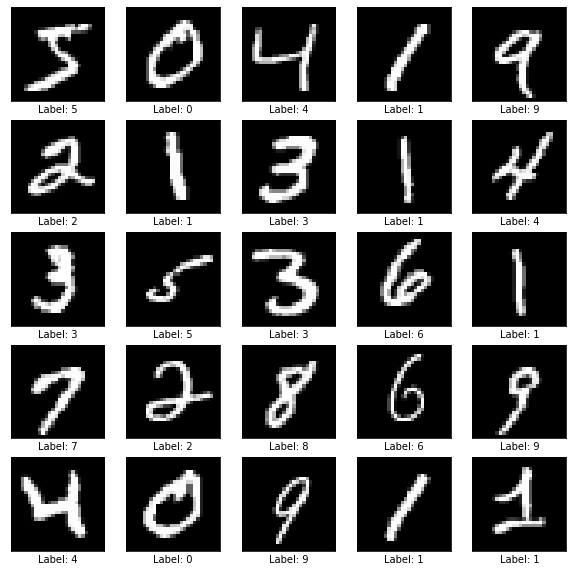

In [4]:
# Show the first 25 images in the training dataset.
show_sample(train_images, 
            ['Label: %s' % label for label in train_labels])

In [5]:
# Define the model architecture
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),

# Optional: You can replace the dense layer above with the convolution layers below to get higher accuracy.
    # keras.layers.Reshape(target_shape=(28, 28, 1)),
    # keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
    # keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
    # keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # keras.layers.Dropout(0.25),
    # keras.layers.Flatten(input_shape=(28, 28)),
    # keras.layers.Dense(128, activation=tf.nn.relu),
    # keras.layers.Dropout(0.5),

    keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [6]:
# Train the digit classification model
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 2.4426 - accuracy: 0.8633
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3502 - accuracy: 0.9171
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2729 - accuracy: 0.9295
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2524 - accuracy: 0.9363
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2299 - accuracy: 0.9430


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


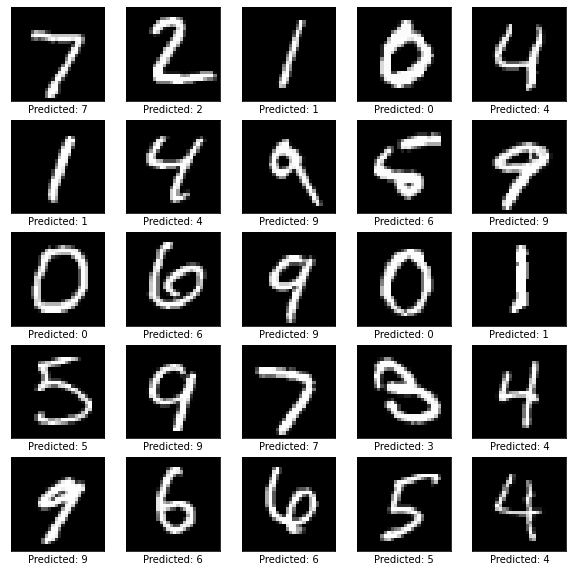

In [9]:
# Evaluate the model using test dataset.
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:{0} ===> {1}%'.format(test_acc, round(test_acc*100)))

# Predict the labels of digit images in our test dataset.
predictions = model.predict(test_images)

# Then plot the first 25 test images and their predicted labels.
show_sample(test_images, 
            ['Predicted: %d' % np.argmax(result) for result in predictions])

In [10]:
# Save the model.
model_path = 'saved_model/mnist_model'
model.save(model_path)
print("DigitalCalssifier가 SavedModel로 저장되었습니다.")

INFO:tensorflow:Assets written to: saved_model/mnist_model/assets
DigitalCalssifier가 SavedModel로 저장되었습니다.


In [11]:
# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpptz9k559/assets


In [12]:
# Save the TF Lite model as file
f = open('mnist.tflite', "wb")
f.write(tflite_model)
f.close()

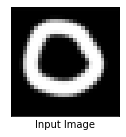

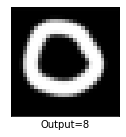

Predicted Digit: 8
Confidence: 0.7456689476966858 ===> 75%


In [13]:
###################### Verifying the '.tflite' file #######################

# CAUTION ###################################################
# However, this model is FAILED. This code doesn't work well.
# There is an only output result = 8
# The .tflite file only can read every digit as 8
#############################################################

# Download a test image
zero_img_path = keras.utils.get_file(
    'zero.png', 
    'https://storage.googleapis.com/khanhlvg-public.appspot.com/digit-classifier/zero.png'
    )

image = keras.preprocessing.image.load_img(
    zero_img_path,
    color_mode = 'grayscale',
    target_size=(28, 28),
    interpolation='bilinear'
    )

# Pre-process the image: Adding batch dimension and normalize the pixel value to [0..1]
# In training, we feed images in a batch to the model to improve training speed, making the model input shape to be (BATCH_SIZE, 28, 28).
# For inference, we still need to match the input shape with training, so we expand the input dimensions to (1, 28, 28) using np.expand_dims
input_image = np.expand_dims(np.array(image, dtype=np.float32) / 255.0, 0)

# Show the pre-processed input image
show_sample(input_image, ['Input Image'], 1)

# Read lite model for tensorflow
# tflite_model = None
tflite_path= "mnist.tflite"
with open(tflite_path, 'rb') as f:
  tflite_model= f.read()

# Run inference with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
interpreter.set_tensor(interpreter.get_input_details()[0]["index"], input_image)
interpreter.invoke()
output = interpreter.tensor(interpreter.get_output_details()[0]["index"])()[0] 

# Print the model's classification result
digit = np.argmax(output)

show_sample(input_image, ['Output={}'.format(digit)], 1)
print('Predicted Digit: {0}\nConfidence: {1} ===> {2}%'.format(digit, output[digit], round(output[digit]*100)))